# Pat & Steve's Statistics Smorgasbord

In [1]:
## do this if you have not installed astroML yet
# !mamba install -c astropy astroML
## or this
# !pip install astroML

In [2]:
# Execute this cell
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstats

## (1) Descriptive statistics & data moments

In [3]:
# Execute this cell
#------------------------------------------------------------
# Let's generate some data: a mix of several Cauchy distributions
random_state = np.random.RandomState(seed=0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
hx = lambda x: sum([f * scipy.stats.cauchy(mu, gamma).pdf(x)
                    for (mu, gamma, f) in mu_gamma_f])
data = np.concatenate([scipy.stats.cauchy(mu, gamma).rvs(int(f * N), 
                                                         random_state=random_state)
                       for (mu, gamma, f) in mu_gamma_f])
random_state.shuffle(data)
data = data[data > -10]
data = data[data < 30]

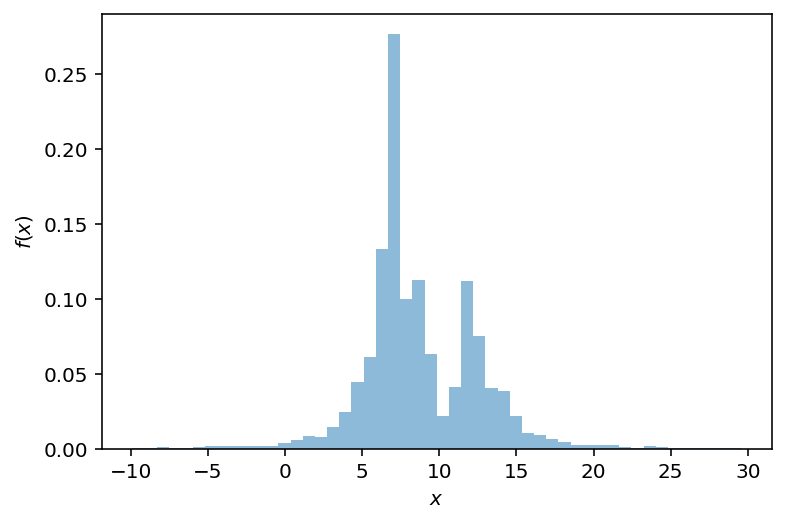

In [4]:
# Execute this cell
# make a histogram to get an idea of what the distribution looks like
plt.hist(data, bins=50, density=True, alpha=0.5);
plt.xlabel('$x$');
plt.ylabel('$f(x)$');

We all know that the **mean** of a sample is 

$$\bar{x} = \frac{1}{N}\sum_{i=1}^N x_i$$ 

This is actually known as the **sample arithmetic mean**, and derives from *Monte Carlo integration* to get the first moment of the distribution, i.e. 

$$\mu = E(x) = \langle x \rangle = \int_{-\infty}^{\infty} x\, h(x)\,dx \approx \frac{1}{N}\sum_{i=1}^N x_i $$

where $\{x_i\}$ are random samples from the properly normalized $h(x)$, and $E(\cdot)$ means the **expectation value**. In general we can use random sampling and Monte Carlo integration to deduce integrals over distributions such that 

$$\int_{-\infty}^{\infty} g(x) h(x)\,dx \approx \frac{1}{N}\sum_{i=1}^N g(x_i)$$

In [5]:
# Execute this cell
mean = np.mean(data)
print(mean)

8.707331724932475


While it's most common to compute the mean, it may surprise you to learn that some distributions do not have formally calculable means (integration gives infinity). In these and other cases, the **median** is a more *robust* estimator of the (true) mean location of the distribution.  That's because it is less affected by **outliers**.

To understand the previous statement, think about multiplying all numbers above the 50th percentile (i.e. the median) by 100, or even just replacing them with larger numbers. The mean would be strongly affected by these corrupted points, but **cumulative statistics based on the ordering of samples would remain unaffected by the outlier corruption**.

In [6]:
# Execute this cell.  Think about and discuss what it is doing.
median = np.median(data)

mask = data > 15
data2 = data.copy()
data2[mask] = 100

newmedian = np.median(data2)
newmean = np.mean(data2)

print(median, newmedian)
print(mean, newmean)

7.665858989040229 7.665858989040229
8.707331724932475 12.230618259322716


<font color='red'>Repeat the above masking investigation, but this time multiply all samples above $15$ by a factor of 10. Do you get a similar effect?</font>

In [7]:
# Execute this cell.  Think about and discuss what it is doing.
median = np.median(data)

mask = data > 15
data2 = data.copy()
data2[mask] *= 10

newmedian = np.median(data2)
newmean = np.mean(data2)

print(median, newmedian)
print(mean, newmean)

7.665858989040229 7.665858989040229
8.707331724932475 15.637361318438858


Other descriptive statistics are related to higher order moments of the distribution. Beyond the "average" *location* value, we'd like to know something about **deviations** from the average (which is related to the *shape* of the distribution).  The simplest thing to compute is $$d_i = x_i - \mu.$$  However, the average deviation is zero by definition of the mean.  The next simplest thing to do is to compute the **mean absolute deviation (MAD)**:

$$\frac{1}{N}\sum|x_i-\mu|,$$

but the absolute values can hide the true scatter of the distribution [in some cases (see footnote)](http://www.mathsisfun.com/data/standard-deviation.html).  So the next simplest thing to do is to square the differences $$\sigma^2 = \frac{1}{N}\sum(x_i-\mu)^2,$$ which we call the **variance**.

The *variance* $V$ is just expectation value of $(x-\mu)^2$ (and related to the 2nd moment)

$$\sigma^2 = V = E((x-\mu)^2)\int_{-\infty}^{\infty}  (x-\mu)^2 h(x) dx,$$

where $\sigma$ is the **standard deviation**. Again, the integral gets replaced by a sum for discrete distributions. While most familiar for Gaussian distributions, you can compute the variance even if your distribution is not Gaussian.  

In [8]:
# Execute this cell
var = np.var(data)
std = np.std(data)
print(var, std)

14.109284000694963 3.75623268724063


**$P\%$ quantiles (or the $p^\mathrm{th}$ percentile, $q_p$)** are computed as
$$\frac{p}{100} = H(q_p) = \int_{-\infty}^{q_p}h(x) dx$$

The full integral from $-\infty$ to $\infty$ is 1 (100%).  So, here you are looking for the value of x that accounts for $p$ percent of the distribution.

For example, the 25th, 50th, and 75th percentiles:

In [9]:
# Execute this cell
q25, q50, q75 = np.percentile(data, [25, 50, 75])
print(q25, q50, q75)

6.674244809830177 7.665858989040229 11.61720224123862


The **interquartile range** is the difference between the 25th and 75th percentiles, $q_{75} - q_{25}$.

Just as with the median, the interquartile range is a more *robust* estimator of the scale of a distribution than the standard deviation.  So, one can create a standard-deviation-esque measurement (at least for a Gaussian) from the interquartile range as

$$\sigma_G = 0.7413\times(q_{75} - q_{25})$$  

The normalization makes it *unbiased* for a perfect Gaussian (more on that later).

My Question: where does 0.7413 come from?

Other useful ***shape*** measures include the "higher order" moments (the **skewness** and **kurtosis**):

$$\mathbf{Skewness}\quad\quad \Sigma = \int_{-\infty}^{\infty}  \left(\frac{x-\mu}{\sigma}\right)^3 h(x) dx,$$
 
$$\mathbf{Kurtosis}\quad\quad K = \int_{-\infty}^{\infty}  \left(\frac{x-\mu}{\sigma}\right)^4 h(x) dx  - 3.$$

The skewness measures the distribution's *asymmetry*. Distribution's with long tails to larger $x$ values have positive $\Sigma$. 

The kurtosis measures how peaked or flat-topped a distribution is, with strongly peaked ones being positive and flat-topped ones being negative. $K$ is calibrated to a Gaussian distribution (hence the subtraction of $3$).

![https://www.astroml.org/_images/fig_kurtosis_skew_1.png](https://www.astroml.org/_images/fig_kurtosis_skew_1.png)

In [10]:
# Execute this cell
skew = scipy.stats.skew(data)
kurt = scipy.stats.kurtosis(data)
print(skew, kurt)

0.37223965431728584 2.8833035420731363


In [11]:
# Excute this cell
# Summary descriptive statistics for our distribution
print("Location: ", mean, median)
print("Scale: ", var, std, astroMLstats.sigmaG(data))
print("Shape: ", skew, kurt)
print("Some percentiles: ", q25, q50, q75)

Location:  8.707331724932475 7.665858989040229
Scale:  14.109284000694963 3.75623268724063 3.6642198268924555
Shape:  0.37223965431728584 2.8833035420731363
Some percentiles:  6.674244809830177 7.665858989040229 11.61720224123862


## (2) Univariate distributions <a class="anchor" id="three"></a>

If we are attempting to characterize our data in a way that is **parameterized**, then we need a functional form for a **distribution**.  There are many naturally occurring distributions.  The book goes through quite a few of them.  Here we'll just talk about a few basic ones to get us started.

### Uniform Distribution

The uniform distribution is perhaps more commonly called a "top-hat" or a "box" distribution.  It is specified by a mean, $\mu$, and a width, $W$, where

$$p(x|\mu,W) = \frac{1}{W}$$

over the range $|x-\mu|\le \frac{W}{2}$ and $0$ otherwise.  That says that "given $\mu$ AND $W$, the probability of $x$ is $\frac{1}{W}$" (as long as we are within a certain range).

Since we are used to thinking of a Gaussian as the *only* type of distribution the concept of $\sigma$ (aside from the width) may seem strange.  But $\sigma$ as mathematically defined above applies here and
$$\sigma = \frac{W}{\sqrt{12}}.$$




We can implement [uniform](http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.uniform.html#scipy.stats.uniform) in `scipy` as follows.  We'll use the methods listed at the bottom of the link to complete the cell: `dist.rvs(size=N)` which produces `N` random draws from the distribution and `dist.pdf(x)` which returns the value of the pdf at a given $x$. Lots of distributions can be accessed and used in a similar way.  

Create a uniform distribution with parameters `loc=0`,  `scale=2`, and `N=10`.

<font color='red'>Complete and execute the following cell</font>


In [12]:

N = 10 # Complete
distU = scipy.stats.uniform(loc=0, scale=2) # Complete
draws = distU.rvs(N) # ten random draws
print(draws)

p = distU.pdf(1) # pdf evaluated at x=1

print(p)


[0.99487146 1.51923082 1.66188545 0.96373368 0.43901741 1.80859202
 0.40160587 0.67732051 0.11961115 0.87641367]
0.5



### Gaussian Distribution

As many of you know, the Gaussian distribution pdf is given by

$$p(x|\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x-\mu)^2}{2\sigma^2}\right)$$

It is also called the **normal distribution** and can be noted by $\mathscr{N}(\mu,\sigma)$.


We love using Gaussians in physics and astronomy because they can approximate many distributions and are also super easy to work with. **The convolution of two Gaussians results in a Gaussian.**  So $\mathscr{N}(\mu_1,\sigma_1)$ convolved with $\mathscr{N}(\mu_2,\sigma_2)$ is $\mathscr{N}(\mu_1+\mu_2,\sqrt{\sigma_1^2+\sigma_2^2})$.

Create a [normal distribution](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html?highlight=stats%20norm#scipy.stats.norm) with `loc=100` and `scale=15`. Produce 10 random draws and determine the probability at `x=145`.

<font color='red'>Complete and execute the following cell</font>


In [13]:
mu = 100
sigma = 15
distG = scipy.stats.norm(loc=mu, scale=sigma) # Normal distribution with mean = 100, stdev = 15
draws = distG.rvs(N) # 10 random draws
p = distG.pdf(145) # pdf evaluated at x=0

print(draws)
print(p)


[ 97.49610799  97.79843667 112.62288039  81.36556653  87.04621746
  98.83337179 105.86063564 101.48427227  75.93674447  95.45267388]
0.0002954565607958672



Make a plot of this Gaussian distribution. Plot the pdf from 0 to 200 with a 1000 gridpoints.  

<font color='red'>Complete and execute the following cell</font>


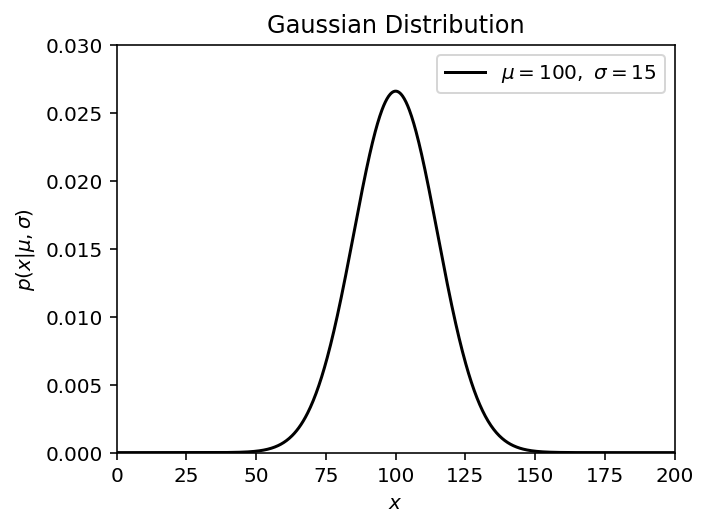

In [14]:

## Let's play with Gaussians! Or Normal distributions, N(mu,sigma)

xgrid = np.linspace(0, 200, num=1000) # generate distribution for a uniform grid of x values
gaussPDF = distG.pdf(xgrid)  # this is a function of xgrid

# actual plotting
fig, ax = plt.subplots(figsize=(5, 3.75))

# Python3 f strings are awesome!
plt.plot(xgrid, gaussPDF, ls='-', c='black', 
         label=f'$\mu={mu},\ \sigma={sigma}$')
plt.xlim(0, 200)
plt.ylim(0, 0.03)
plt.xlabel('$x$')
plt.ylabel(r'$p(x|\mu,\sigma)$')
plt.title('Gaussian Distribution')
plt.legend()



The cumulative distribution function, cdf is the integral of pdf from $x'=-\infty$ to $x'=x$:

$$\mathrm{cdf}(x|\mu,\sigma) = \int_{-\infty}^{x'} p(x'|\mu,\sigma) dx',$$

where $\mathrm{cdf}(\infty) = 1$. 


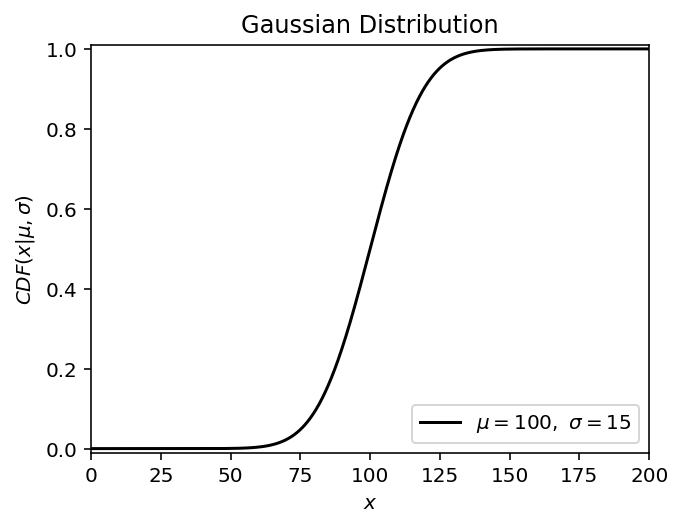

In [15]:

# The same as above but now with the cdf method
gaussCDF = distG.cdf(xgrid)
fig, ax = plt.subplots(figsize=(5, 3.75))
plt.plot(xgrid, gaussCDF, ls='-', c='black', 
         label=r'$\mu=%i,\ \sigma=%i$' % (mu, sigma))
plt.xlim(0, 200)
plt.ylim(-0.01, 1.01)
plt.xlabel('$x$')
plt.ylabel(r'$CDF(x|\mu,\sigma)$')
plt.title('Gaussian Distribution')
plt.legend(loc=4)



#### Gaussian confidence levels

The probability of a measurement drawn from a Gaussian distribution that is between $\mu-a$ and $\mu+b$ is

$$\int_{\mu-a}^{\mu+b} p(x|\mu,\sigma) dx.$$

- For $a=b=1\sigma$, we get the familar result of 68.3%.  
- For $a=b=2\sigma$ it is 95.4%.  
- For $a=b=3\sigma$ it is $99.7\%$. 

So we refer to the range $\mu \pm 1\sigma$, $\mu \pm 2\sigma$, and $\mu \pm 3\sigma$ as the 68%, 95%, and $99.7%$ **confidence limits**, respectively. Note that if your distribution is not Gaussian, then these confidence intervals will be different!

***We often still refer to uncertainty regions of distributions as $1\sigma$ or $2\sigma$ regions, which for non-Gaussian distributions usually means (for $1\sigma$) the region enclosing the $16\%$ and $84\%$ quantiles.***

What is the probability enclosed between $-2\sigma$ and $+4\sigma$? (*Verify first that you get the correct answer for the bullet points above!*)

<font color='red'>Complete and execute the following cell</font>


In [16]:

N=10000
mu=0
sigma=1
distN = scipy.stats.norm(mu, sigma) # Complete
xgrid = np.linspace(-sigma, sigma, N) # Complete
dx = (xgrid.max()-xgrid.min())/N
prob = distN.pdf(xgrid)*dx

print(prob.sum())

xgrid = np.linspace(-2 * sigma, 2 * sigma, N) # Complete
dx = (xgrid.max()-xgrid.min())/N
prob = distN.pdf(xgrid)*dx

print(prob.sum())

xgrid = np.linspace(-3 * sigma, 3 * sigma, N) # Complete
dx = (xgrid.max()-xgrid.min())/N
prob = distN.pdf(xgrid)*dx

print(prob.sum())

xgrid = np.linspace(-2 * sigma, 4 * sigma, N) # Complete
dx = (xgrid.max()-xgrid.min())/N
prob = distN.pdf(xgrid)*dx

print(prob.sum())


0.6826696157194765
0.9544258796368303
0.9972031322275808
0.977136709173485



We could do this in various ways. The way you just tried was the most obvious-- brute-force numerical integration with the trapezoidal method. 

But the clever way is to use the cdf, by computing the cdf of the upper integration bound and subtracting the cdf of the lower integration bound.

<font color='red'>Complete and execute the following cell</font>


In [17]:

upper = distN.cdf(4 * sigma)
lower = distN.cdf(-2 * sigma)
p = upper-lower
print(p)


0.9772181968099877




### $\chi^2$ Distribution

We'll run into the $\chi^2$ distribution when we talk about Maximum Likelihood in the next chapter.

If we have a Gaussian distribution with values ${x_i}$ and we scale and normalize them according to
$$z_i = \frac{x_i-\mu}{\sigma},$$
then the sum of squares, $Q$ 
$$Q = \sum_{i=1}^N z_i^2,$$
will follow the $\chi^2$ distribution.  The *number of degrees of freedom*, $k$ is given by the number of data points, $N$ (minus any constraints).  The pdf of $Q$ given $k$ defines $\chi^2$ and is given by
$$p(Q|k)\equiv \chi^2(Q|k) = \frac{1}{2^{k/2}\Gamma(k/2)}Q^{k/2-1}\exp(-Q/2),$$
where $Q>0$ and the $\Gamma$ function would just be the usual factorial function if we were dealing with integers, but here we have half integers.

This is ugly, but it is really just a formula like anything else.  Note that the shape of the distribution *only* depends on the sample size $N=k$ and not on $\mu$ or $\sigma$.  

### Chi-squared per degree of freedom

In practice we frequently divide $\chi^2$ by the number of degrees of freedom, and work with:

$$\chi^2_\mathrm{dof} = \frac{1}{N-1} \sum_{i=1}^N \left(\frac{x_i-\overline{x}}{\sigma}\right)^2$$

which (for large $k$) is distributed as

$$ p(\chi^2_\mathrm{dof}) \sim \mathscr{N}\left(1, \sqrt{\frac{2}{N-1}}\right) $$

(where $k = N-1$, and $N$ is the number of samples). Therefore, we expect $\chi^2_\mathrm{dof}$ to be 1, to within a few $\sqrt{\frac{2}{N-1}}$.

### Poisson distribution

This is a distribution for a discrete variable, telling you the probability of $k$ events occuring within a certain time when the mean is $\mu$. 

An early and famous example of the use of this distribution was to **model the expected number of Prussian cavalrymen that would be kicked to death by their own horse**. Statistics has many applications...

$$ p(k|\mu) = \frac{\mu^k \exp(-\mu)}{k!} $$

where the mean $\mu$ completely characterizes the distribution. The mode is $(\mu-1)$, the standard deviation is $\sqrt{\mu}$, the skewness is $1/\sqrt{\mu}$, and the kurtosis is $1/\mu$.

As $\mu$ increases the Poisson distribution becomes more and more similar to a Gaussian with $\mathcal{N}(\mu,\sqrt{\mu})$. The Poisson distribution is sometimes called the ***law of small numbers*** or ***law of rare events***.

<font color='red'>Complete and execute the following cell for $\mu=3$.</font>


In [18]:

# Practice the Poisson distribution

dist = scipy.stats.poisson(3)

k = dist.rvs(20) # make 20 draws
pmf = dist.pmf(6) # evaluate probability mass function at 6

print(k, pmf)


[0 4 4 1 4 1 1 2 2 3 0 2 3 2 3 2 5 1 5 4] 0.05040940672246224



### Student's $t$ Distribution

Another distribution that we'll see later is the Student's $t$ Distribution.

If you have a sample of $N$ measurements, $\{x_i\}$, drawn from a Gaussian distribution, $\mathscr{N}(\mu,\sigma)$, and you apply the transform

$$t = \frac{\overline{x}-\mu}{s/\sqrt{N}},$$

then $t$ will be distributed according to Student's $t$ with the following pdf (for $k$ degrees of freedom):

$$p(x|k) = \frac{\Gamma(\frac{k+1}{2})}{\sqrt{\pi k} \Gamma(\frac{k}{2})} \left(1+\frac{x^2}{k}\right)^{-\frac{k+1}{2}}$$

As with a Gaussian, Student's $t$ is bell shaped, but has "heavier" tails.

Note the similarity between $t$ and $z$ for a Gaussian (as defined in the $\chi^2$ section above), which reflects the difference between data-derived estimates of the mean and standard deviation and their true values.

In fact, although often approximated as a Gaussian distribution, the mean of a sample actually follows a Student's $t$ distribution. This matters when sample sizes are small, but mostly irrelevant for "Big Data" examples.

### What's the point of all these distributions?

* There are many other distributions that we haven't covered here.
* The point is that we want make measurements. 
* To understand the significance of our measurement, we want to know how likely it is that we would get that measurement in our experiment by random chance. 
* To determine that we need to know the shape of the distribution. Let's say that we find that $x=6$. If our data is $\chi^2$ distributed with 2 degrees of freedom, then we would integrate the $k=2$ curve above from 6 to $\infty$ to determine how likely it is that we would have gotten 6 or larger by chance.  If our distribution was instead $t$ distributed, we would get a *very* different answer.  

**FUN FACT:** "Student" was the pen name of W. S. Gosset, who worked for the Guinness brewery in Dublin, Ireland. He was interested in the statistical analysis of small samples, e.g., the chemical properties of barley when the sample size might be as small as $3$.

![https://thatsmaths.files.wordpress.com/2014/04/gosset-plaque.jpg](https://thatsmaths.files.wordpress.com/2014/04/gosset-plaque.jpg)

## (3) Central Limit Theorem <a class="anchor" id="one"></a>

One of the reasons that a Gaussian (or Normal) Distribution is so common is because of the **Central Limit Theorem**:

> For an arbitrary distribution, $h(x)$, with a well-defined mean, $\mu$, and standard deviation, $\sigma$ (i.e. tails should fall off faster than $1/x^2$) the mean of $N$ values \{$x_i$\} drawn from the distribution will follow a Gaussian Distribution with $\mathcal{N}(\mu,\sigma/\sqrt{N})$. (A Cauchy distribution is one example where this fails.)

This theorem is the foundation for performing repeat measurements in order to improve the accuracy of one's experiment. This is truly amazing! No matter what distribution you start off with (provided it has a well defined mean and standard deviation) or the measurement process itself, repeated batches of $N$ draws will follow a Gaussian centered around the mean.  

The **Weak Law of Large Numbers** (aka **Bernoulli's Theorem**) further says that the sample mean will converge to the distribution mean as $N$ increases.

Let's wrap our heads around what this means with some examples. 

We'll first consider $h(x) = \mathcal{N}(\mu=0.5,\sigma=1/\sqrt{12})$. According to the Central Limit Theorem, taking the mean of many batches of $N$ random samples should result in a normal distribution with $\mathcal{N}(\mu=0.5,\sigma=1/\sqrt{12}/\sqrt{N})$.

<font color='red'>Complete and execute the following cell</font>


Text(0, 0.5, 'pdf')

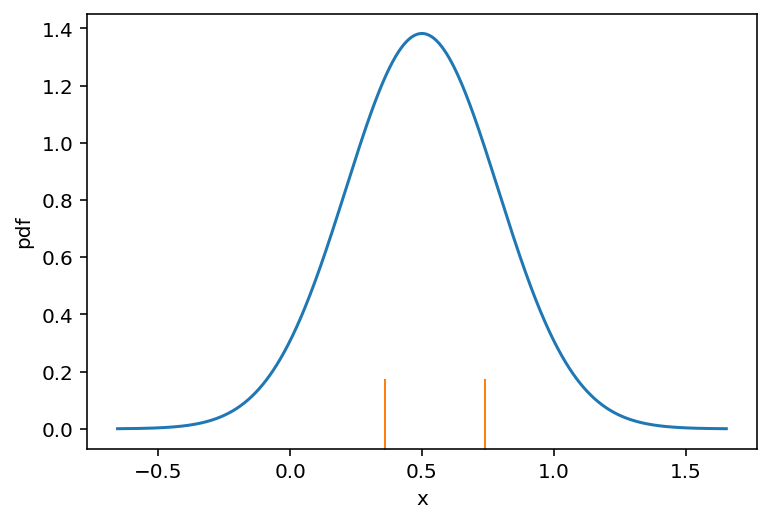

In [19]:

N = 2 # Number of draws
mu = 0.5 # Location
sigma_h = 1.0 / np.sqrt(12) # scale of h(x)

xgrid = np.linspace(mu - 4 * sigma_h, mu + 4 * sigma_h, 1000) # Array to sample the space 
distG = scipy.stats.norm(loc=mu, scale=sigma_h) # Complete
plt.plot(xgrid, distG.pdf(xgrid)) # Complete

x = np.random.normal(mu, sigma_h, 2) # Two random draws
plt.plot(x, 0 * x, '|', markersize=50)
plt.xlabel('x')
plt.ylabel('pdf')



Now let's average those two draws and plot the result (in the same panel). Do it as a histogram for 100,000 batches of 2 samples each. Use a stepfilled histogram that is normalized with 50% transparency and 100 bins.

<font color='red'>Complete and execute the following cell</font>


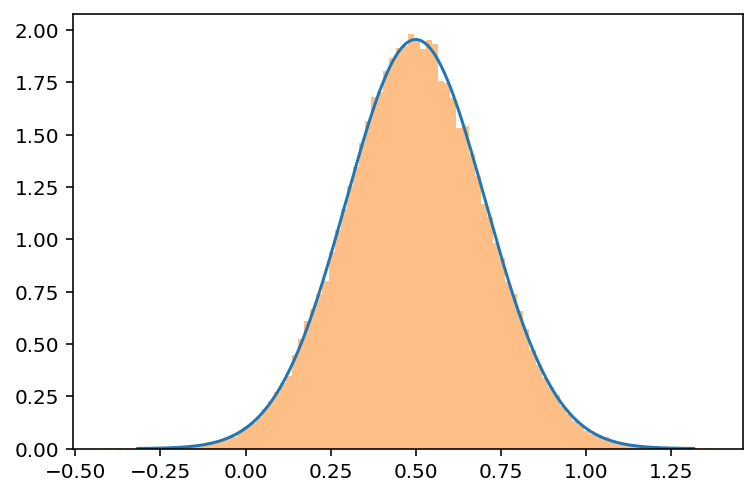

In [20]:

from scipy.stats import norm

N = 2 # Number of draws
mu = 0.5 # Location
sigma_h = 1.0 / np.sqrt(12) # scale of h(x)
sigma_cl = sigma_h / np.sqrt(N) # scale of mean error distribution

xgrid = np.linspace(mu - 4 * sigma_cl, mu + 4 * sigma_cl, 1000) # Array to sample the space 

# plot the distribution of means according to central limit theorem
distG = norm(mu, sigma_cl) # Complete
plt.plot(xgrid, distG.pdf(xgrid)) # Complete

# Add a histogram that is the mean of 100,000 batches of N draws
yy = []
for i in np.arange(100000):
    xx = np.random.normal(loc=mu, scale=sigma_h, size=N) # N random draws
    yy.append(np.mean(xx)) # Append average of those random draws to the end of the array

_ = plt.hist(yy, bins=100, histtype='stepfilled', alpha=0.5, density=True)



Well that's great and all, but didn't I say this worked for arbitrary generating distributions $h(x)$ so long as their mean and standard deviations were well defined? Let's check this out for a uniform distribution with $\mu=0.5$ and width$ =1$.

<font color='red'>Complete the following cell</font>


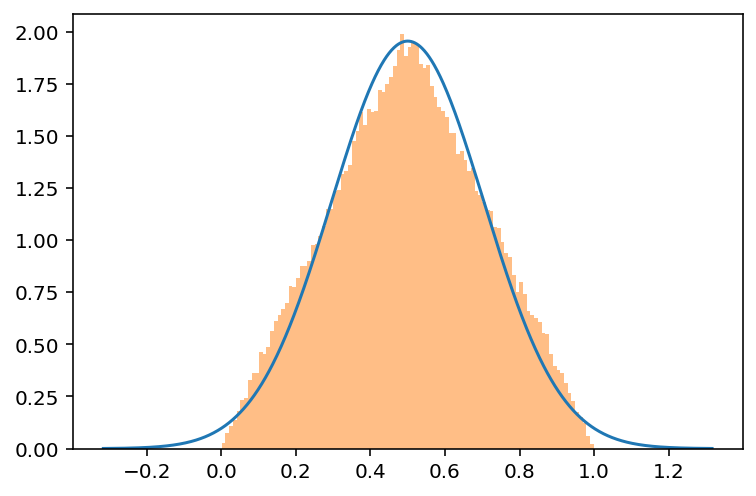

In [21]:

N = 2 # Number of draws
mu = 0.5 # Location
width = 1
sigma_h = width / np.sqrt(12)  # scale of h(x)
sigma_cl = sigma_h / np.sqrt(N) # scale of mean error distribution

# Complete the rest of this cell with a repetition of the the previous exercise,
# except drawing N-sample batches from a [0,1] uniform distribution, and plotting
# the distribution of the means of those batches. Show that the distribution
# matches that implied by the central limit theorem.

xgrid = np.linspace(mu - 4 * sigma_cl, mu + 4 * sigma_cl, 1000) # Array to sample the space 

# plot the distribution of means according to central limit theorem
distG = norm(mu, sigma_cl) # Complete
plt.plot(xgrid, distG.pdf(xgrid)) # Complete

# Add a histogram that is the mean of 100,000 batches of N draws
yy = []
for i in np.arange(100000):
    xx = np.random.uniform(low=mu-(width/2), high=mu+(width/2), size=N) # N random draws
    yy.append(np.mean(xx)) # Append average of those random draws to the end of the array

_ = plt.hist(yy, bins=100, histtype='stepfilled', alpha=0.5, density=True)




Now instead of averaging 2 draws, average 3.  Then do it for 10.  Then for 100.  Each time for 100,000 samples.


<font color='red'>Copy your code from above and edit accordingly (or just edit your code from above)</font>



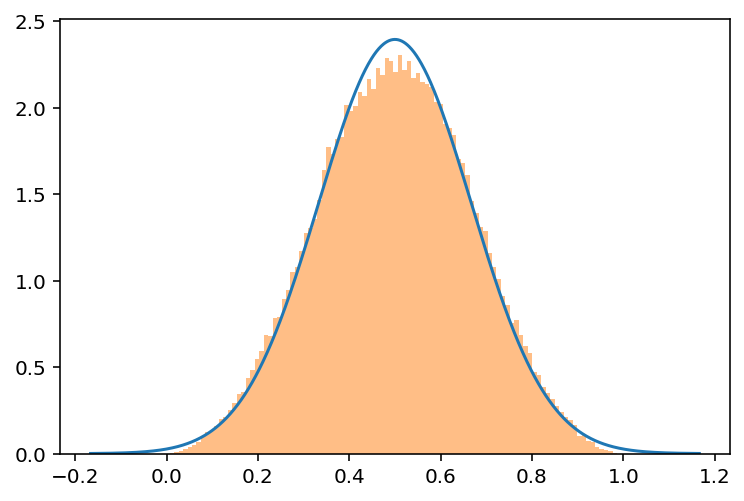

In [22]:

N = 3 # Number of draws
mu = 0.5 # Location
width = 1
sigma_h = width / np.sqrt(12)  # scale of h(x)
sigma_cl = sigma_h / np.sqrt(N) # scale of mean error distribution

# Complete the rest of this cell with a repetition of the the previous exercise,
# except drawing N-sample batches from a [0,1] uniform distribution, and plotting
# the distribution of the means of those batches. Show that the distribution
# matches that implied by the central limit theorem.

xgrid = np.linspace(mu - 4 * sigma_cl, mu + 4 * sigma_cl, 1000) # Array to sample the space 

# plot the distribution of means according to central limit theorem
distG = norm(mu, sigma_cl) # Complete
plt.plot(xgrid, distG.pdf(xgrid)) # Complete

# Add a histogram that is the mean of 100,000 batches of N draws
yy = []
for i in np.arange(100000):
    xx = np.random.uniform(low=mu-(width/2), high=mu+(width/2), size=N) # N random draws
    yy.append(np.mean(xx)) # Append average of those random draws to the end of the array

_ = plt.hist(yy, bins=100, histtype='stepfilled', alpha=0.5, density=True)



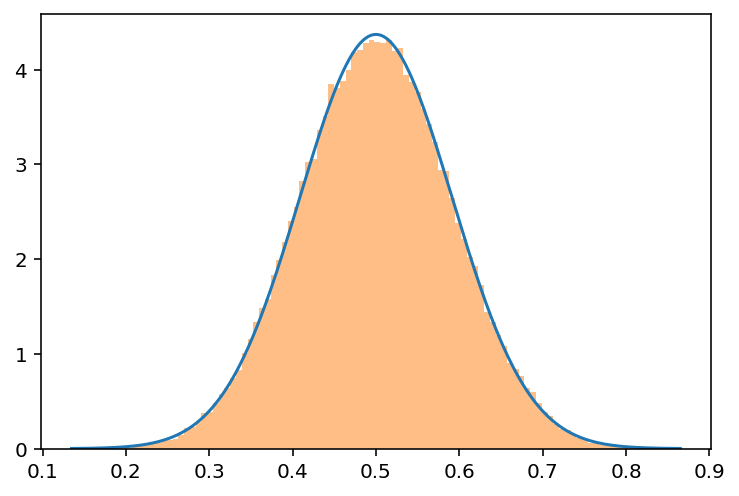

In [23]:

N = 10 # Number of draws
mu = 0.5 # Location
width = 1
sigma_h = width / np.sqrt(12)  # scale of h(x)
sigma_cl = sigma_h / np.sqrt(N) # scale of mean error distribution

# Complete the rest of this cell with a repetition of the the previous exercise,
# except drawing N-sample batches from a [0,1] uniform distribution, and plotting
# the distribution of the means of those batches. Show that the distribution
# matches that implied by the central limit theorem.

xgrid = np.linspace(mu - 4 * sigma_cl, mu + 4 * sigma_cl, 1000) # Array to sample the space 

# plot the distribution of means according to central limit theorem
distG = norm(mu, sigma_cl) # Complete
plt.plot(xgrid, distG.pdf(xgrid)) # Complete

# Add a histogram that is the mean of 100,000 batches of N draws
yy = []
for i in np.arange(100000):
    xx = np.random.uniform(low=mu-(width/2), high=mu+(width/2), size=N) # N random draws
    yy.append(np.mean(xx)) # Append average of those random draws to the end of the array

_ = plt.hist(yy, bins=100, histtype='stepfilled', alpha=0.5, density=True)



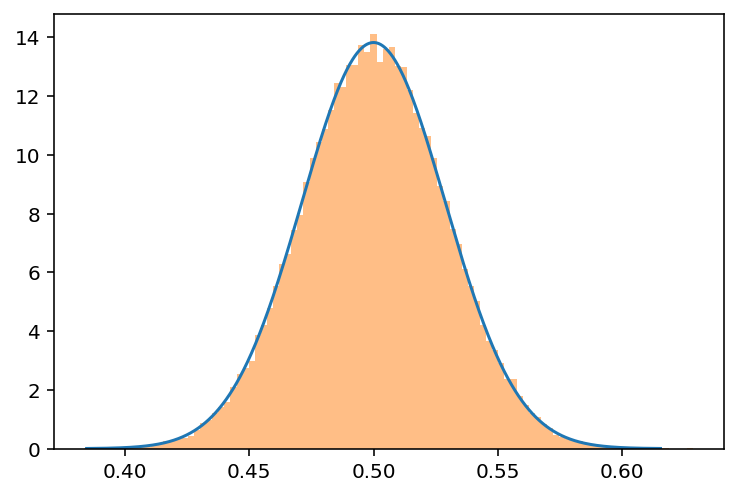

In [24]:

N = 100 # Number of draws
mu = 0.5 # Location
width = 1
sigma_h = width / np.sqrt(12)  # scale of h(x)
sigma_cl = sigma_h / np.sqrt(N) # scale of mean error distribution

# Complete the rest of this cell with a repetition of the the previous exercise,
# except drawing N-sample batches from a [0,1] uniform distribution, and plotting
# the distribution of the means of those batches. Show that the distribution
# matches that implied by the central limit theorem.

xgrid = np.linspace(mu - 4 * sigma_cl, mu + 4 * sigma_cl, 1000) # Array to sample the space 

# plot the distribution of means according to central limit theorem
distG = norm(mu, sigma_cl) # Complete
plt.plot(xgrid, distG.pdf(xgrid)) # Complete

# Add a histogram that is the mean of 100,000 batches of N draws
yy = []
for i in np.arange(100000):
    xx = np.random.uniform(low=mu-(width/2), high=mu+(width/2), size=N) # N random draws
    yy.append(np.mean(xx)) # Append average of those random draws to the end of the array

_ = plt.hist(yy, bins=100, histtype='stepfilled', alpha=0.5, density=True)





For 100 you will note that your draws are clearly sampling the full range, but the means of those draws are in a *much* more restrictred range. Moreover they are very closely following a Normal Distribution. 

This is truly mind blowing, and a wonderful example of the power and generalizability of statistics in tackling the measured properties of arbitrary distributions. Even if you've never heard of or understood the Central Limit Theorem, you have been implicitly using it your entire career so far. 

If you are confused, then watch this video from the Khan Academy:
[https://www.khanacademy.org/math/statistics-probability/sampling-distributions-library/sample-means/v/central-limit-theorem](https://www.khanacademy.org/math/statistics-probability/sampling-distributions-library/sample-means/v/central-limit-theorem).

## (4) Sampling from arbitrary distributions <a class="anchor" id="four"></a>

Numerical simulations of the measurment process are often the only practical way to assess the complicated influences of selection effects, biases, and other processing stages of data taking. Such approaches are often called **Monte Carlo simulations**, producing **Monte Carlo or mock samples**. It is often highly beneficial to resample from arbitrary distributions in order to simulate further measurements.

Imagine you've got an arbitrary distribution $h(x)$ in analytic or histogram form (or alternatively just samples from it). How do you make more samples if it's not one of the standard distributions in `numpy` or `scipy`? We'll discuss the 1D case here in two ways. **Rejection sampling** (less preferred) and **Inverse transform sampling** (highly preferred and easy).

We'll use our samples drawn from a mix of Cauchy distributions (from the top of the notebook) in these examples.

<font color='red'>Make a numpy histogram object out of the data with `density=True` and `bins=50`. This will return a tuple of bin heights and bin edges.</font>


In [47]:
data_counts, data_bins = np.histogram(data, density=True, bins=50)


### Rejection sampling

The process for sampling from an arbitrary distribution with rejection is:

1) Decide on a straightforward *proposal distribution* $q(x)$ to propose new samples. It should be wide enough to capture the tails of $h(x)$. We'll use a uniform distribution here.

2) Generate a random sample from $q(x)$, $x_i$.

3) Now generate a random sample, $u$, from a uniform distribution in the range $[0,\mathrm{max}(h(x))]$, where the upper bound should be as large or larger than the maximum density of $h(x)$. (This could be worked out analytically or by histograming the data.)

4) If $u\leq h(x_i)$ accept the point, or else reject it and try again from step 2.


This is shown pictorally here

![image.png](https://thatnerd2.github.io/img/reject.png)

Let's try this for a simple Gaussian.


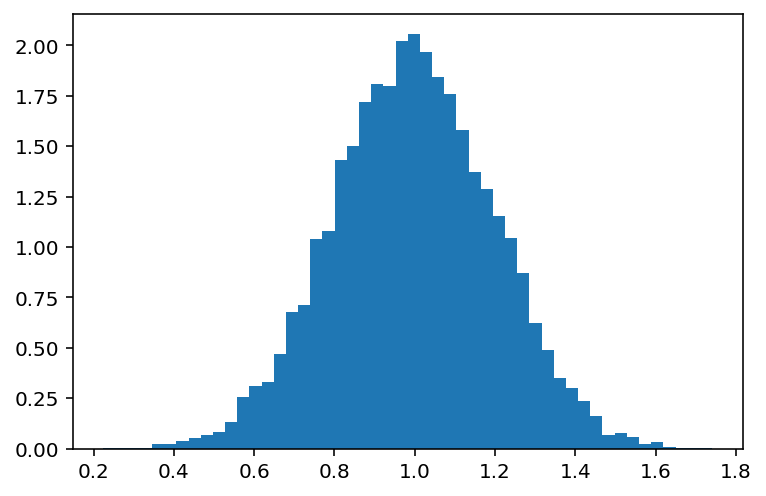

In [48]:

# Execute this cell

# make some sample data
sample_data = np.random.normal(1.0,0.2,10000)

# make a simple histogram object
counts, bins = np.histogram(sample_data, bins=50, density=True)
maxh = counts.max() # find the maximum

# Make a scipy.stats random variable object from a histogram
# This is a great hack!
disth = scipy.stats.rv_histogram((counts,bins))  # holy shit I wish I knew about this 3 months ago

N = 100000 # trials
q = np.random.uniform(0.0, 2.0, N) # proposed points
u = np.random.uniform(0, maxh, N) # uniform draws

mask = u<=disth.pdf(q) # assess whether u <= q(x_i) in the smart pythonic way

monte_carlo = q[mask] # reject all points that don't pass, using masking

plt.hist(monte_carlo, bins=50, density=True);



...of course once you have the `disth` you can immediately draw from the pdf using `disth.rvs()`. This is worth knowing for your own research. It's a great hack, but it's important to know the theory behind all this.

<font color='red'>Use this process to generate at least $1000$ new samples of the Cauchy-mix (i.e. the `data` sample), and make a plot that shows histograms of the original data and the new Monte Carlo samples to compare.</font>



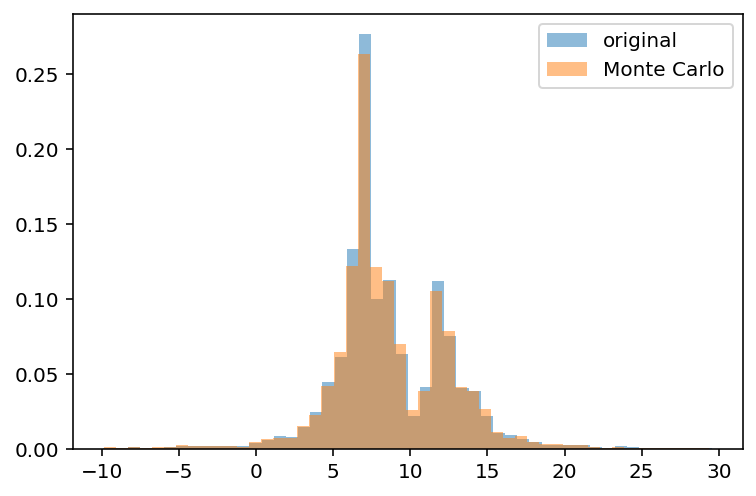

In [49]:
# make a simple histogram object
data_maxh = data_counts.max() # find the maximum

# Make a scipy.stats random variable object from a histogram
# This is a great hack!
data_disth = scipy.stats.rv_histogram((data_counts, data_bins))  # holy shit I wish I knew about this 3 months ago

N = 100000 # trials
q = np.random.uniform(-10, 30, N) # proposed points
u = np.random.uniform(0, data_maxh, N) # uniform draws

mask = u<=data_disth.pdf(q) # assess whether u <= q(x_i) in the smart pythonic way

monte_carlo = q[mask] # reject all points that don't pass, using masking

plt.hist(data, bins=50, density=True, label='original', alpha=.5)
plt.hist(monte_carlo, bins=50, density=True, label='Monte Carlo', alpha=.5)

plt.legend()
plt.show()




### Inverse transform sampling

Rejection sampling works, but wouldn't it be awesome if we didn't have to discard *any* points during our sampling? This is the power and simplicity of **inverse transform sampling**. The process is exceedingly simple. 

1) To sample from an arbitrary $h(x)$, you will also need the cdf $H(x)$ and its inverse, the quantile function $H^{-1}(x)$. If $h(x)$ is difficult to integrate, or $H(x)$ is difficult to invert to get the quantile function, then you could use numerical techniques to interpolate or produce lookup tables.

2) Generate a random sample $u$ from a uniform random distribution $[0,1]$. 

3) Using the quantile function $H^{-1}(x)$, find the value of $x$ below which a fraction $u$ of the distribution is contained. 

4) The $x$ value you get is a random sample from $h(x)$. Easy, right?

Let's try with the Gaussian again.


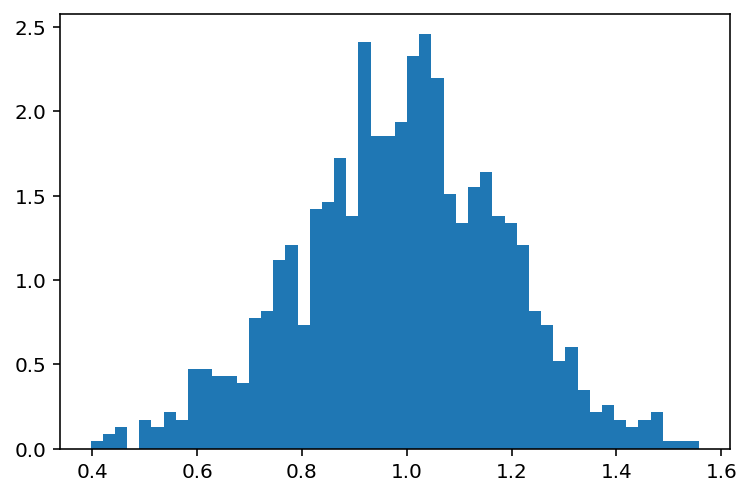

In [50]:

# Execute this cell

# make some sample data
sample_data = np.random.normal(1.0,0.2,10000)

# make a simple histogram object
counts, bins = np.histogram(sample_data, bins=50, density=True)
bin_mids = (bins[1:] + bins[:-1]) / 2 # mid location of bins
 
simple_cdf = np.cumsum(counts) / np.sum(counts) # very simply cumulative sum

# set up an interpolation of the inverse cumulative distribution
tck = scipy.interpolate.interp1d(simple_cdf, bin_mids)

# sample evenly along the cumulative distribution, and interpolate
# little hack to make sure no points are generated outside interpolation range.
# not ideal
u = np.random.uniform(0.001, 0.999, 1000) 
x_sample = tck(u)

plt.hist(x_sample, bins=50, density=True);



<font color='red'>Use this process to generate exactly $1000$ new samples of the Cauchy-mix (i.e. the `data` sample), and make a plot that shows histograms of the original data and the new Monte Carlo samples to compare.</font>



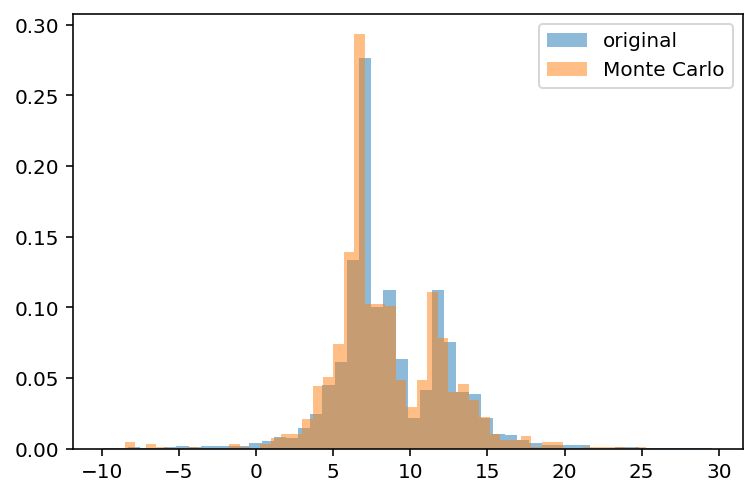

In [51]:

data_bin_mids = (data_bins[1:] + data_bins[:-1]) / 2 # mid location of bins
 
simple_cdf = np.cumsum(data_counts) / np.sum(data_counts) # very simply cumulative sum

# set up an interpolation of the inverse cumulative distribution
tck = scipy.interpolate.interp1d(simple_cdf, data_bin_mids, bounds_error=False, fill_value='extrapolate')

# sample evenly along the cumulative distribution, and interpolate
# little hack to make sure no points are generated outside interpolation range.
# not ideal
u = np.random.uniform(0, 1, 1000) 
x_sample = tck(u)

plt.hist(data, bins=50, density=True, label='original', alpha=.5)
plt.hist(x_sample, bins=50, density=True, label='Monte Carlo', alpha=.5)

plt.legend()
plt.show()




## (5) Stochastic Processes

The most intuitive *starting* discussion for stochatic processes I've found over the years is here: https://www.youtube.com/watch?v=TuTmC8aOQJE&t=689s&ab_channel=MITOpenCourseWare, so I'll be following along from there to start, and then will diverge a bit into some more practical pieces.

A stochastic process is just a time-ordered set of random variables, $\{X_t\}$. It can be either discrete or continuous. For example, a random collection of values...

![screenshot](https://drive.google.com/uc?export=view&id=1YyMLvir0PjLjL7Ofyi_dgQXdybdrT-_x)

Another way of thinking of this is a "probability distribution over paths." Let's look at three examples:

* First: $f(t) = t$ with probability 1. Well, this is just a normal function.

* Alternatively, we could have $f(t) = t$ with probability 1/2 and $f(t)=-t$ with probability 1/2. This is a continuous stochastic process where, when we know the value at one time, we know it at all times. But we have given a simple probability assigned to two separate paths.

* One final example, would be for each $t$, $f(t)=t$ or $f(t) = -t$, each with probability 1/2. So that at each point we sit on one or the other of the two deterministic functions. 

Let's evaluate this last function. Note that, because this is a stochastic process, the path we take is inherently **probabilistic**, and so if you re-run that cell multiple times, you will find a different path. Even though this is a continuous-time stochastic process, we can still evaluate it at a set of discrete points. Try running the cell below several times.

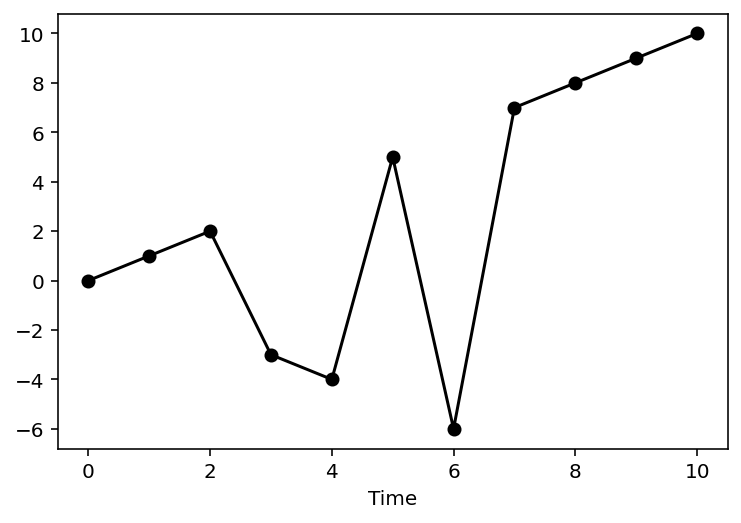

In [57]:
discrete_times = np.linspace(0, 10, num=11) # times from 0 to 100
random_path = []
for ii, t in enumerate(discrete_times):
    # randomly choose from t or -t with equal probability, add it to our stochastic
    # process
    random_path.append(np.random.choice([-t, t]))
plt.plot(discrete_times, random_path, '-o', c='k')
plt.xlabel('Time')
plt.show()

In things like finance, they are interested in **forecasting**...so if they know the path up to some time, they'd like to be able to predict what happens in the future. So they're looking to understand some underlying probabilistic behaviour they can use to predict the future and make money. In the end, even though we're not interested in predicting something about the future, for PTAs we'd also like to understand if that probabibilistic behaviour **matches what we expect**. 

So we'll explore how to take a stochastic process (e.g. pulsar timing residuals), and characterize to understand it.

### Random walk

Let's consider a simple random walk. Define $Y_i = 1$ or $Y_i=-1$ each with probability 1/2. Then define 

$$X_t = \sum_{i=0}^{i=t}Y_i.$$

While this results in a random, different path each time, the **central limit theorem** actually tells us the probability distribution of our position after a long walk. After a long time $\tau$ the value of $X_\tau$ will, on average have a value zero, but a variance of $\tau$. Let's check this!

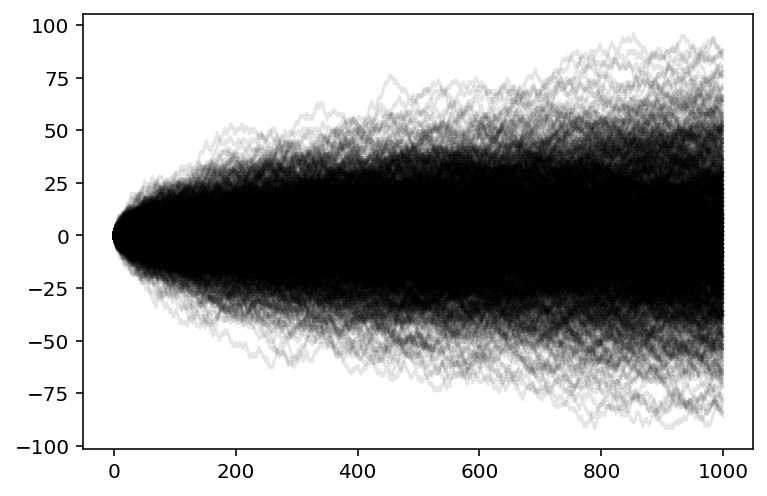

In [58]:
def random_walk(Nsteps):
    Y_is = np.array([np.random.choice([1, -1]) for ii in range(Nsteps)])
    rw = np.cumsum(Y_is)
    return rw
Nsteps = 1000
Nsimulations = 1000
for ii in range(Nsimulations):
    plt.plot(random_walk(Nsteps), c='k', alpha=0.1)
plt.show()

Exercise! Pull out the last value of each realization of the random walk, and create a histogram. Does it look Gaussian? What is the mean of those values? Its variance?

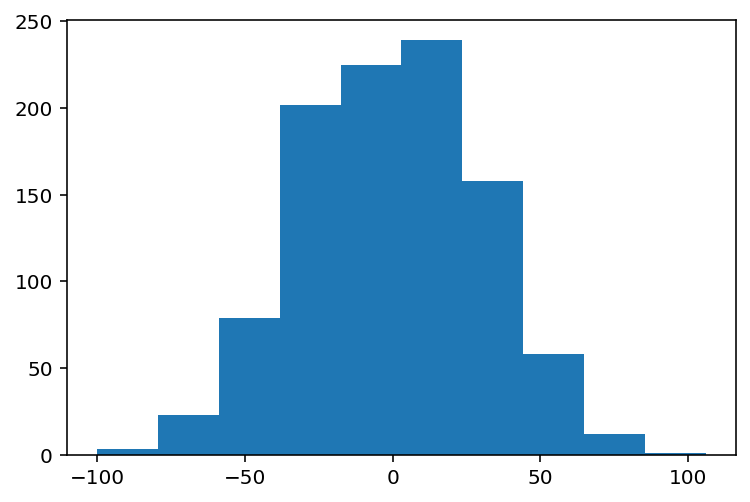

-0.412
922.846256


In [63]:
# Take the ending value of 1000 realisations of a random walk (using random_walk function)
# either in a list comprehension or a loop
random_walk_last_values = np.array([random_walk(Nsteps)[-1] for i in range(Nsimulations)])
plt.hist(random_walk_last_values)
plt.show()

print(np.mean(random_walk_last_values))
print(np.var(random_walk_last_values))


### Autocorrelation function

Ok, let's now define the autocorrelation function. This is the expectation value of the product of our stochastic process at one time with the process at a different time. If we subtract off the mean first, it's called the "auto-covariance function."

Autocorrelation function: $R(X_{t_1}, X_{t_2}) = E[X_{t_1} X_{t_2}].$


Auto-covariance function: $R(X_{t_1}, X_{t_2}) = E[(X_{t_1}-\mu_{t_1})(X_{t_2}-\mu_{t_2})].$

If the autocorrelation function depends only on the time difference between the two points then it is called "**wide-sense stationary**". A nice property of wide-sense stationary processes is that the mean and auto-covariance are time-independent, and so is the variance,

$$R(\tau) = E[X_t X_{t+\tau}].$$

This is what we think of when we think of "random noise" usually. If we have 10 seconds of data from some detector, then the variance will be the same as if we took 100 seconds of data from the same.

Let's look at this for our random walk, though!

Calculate the average of the product $X_{10}X_{15}$ over many realisations of our random walk. What does it come out to? Try to change the values from 10 and 15 to 30 and 50.

In [64]:
corrs_10_15 = []
corrs_30_50 = []
for ii in range(Nsimulations):
    rw = random_walk(51)
    corrs_10_15.append(rw[9] * rw[14])
    corrs_30_50.append(rw[29] * rw[49])
print(np.mean(corrs_10_15))
print(np.mean(corrs_30_50))

10.086
30.324



### Autocorrelation of our random walk [analytic]

Let's try this for the random walk for two points, 10 and 15:

\begin{align}
E[X_{10}X_{15}] = E[(\sum_{i=1}^{10}Y_i)(\sum_{i=1}^{15}Y_i)].
\end{align}

A bit of thought here tells us that if we expand out this product of sums and take their expectation values individually, $E[Y_iY_j]=\delta_{ij}$, and so:

\begin{align}
R(X_{10}X_{15}) = 10\\
R(X_{t_1}X_{t_2})=\min(t_1, t_2).
\end{align}

So a random walk **isn't a wide-sense stationary process!!**

*Notes:* The expansion above is because on average, $E[Y_iY_j] = 0$ when $i \neq j$. However, when $i = j$ this is the same as squaring $Y_{i}$ (or $Y_{j}$), since $Y_{i}$ and $Y_{j}$ are just different steps in the same random walk (this is the key fact here).

### Wiener process

Now, let's take this up a level to a continuous process. Let's define a white noise process $\xi(t)$, where if you evaluate $\xi(t=t_i)$ it is a value randomly drawn from a Gaussian distribution $\cal N(0, 1)$. These are analogous to our "steps." The autocorrelation function is:

$$R(\tau) = \langle \xi(t)\xi(t+\tau)\rangle = \delta(\tau),$$

where $\delta(\tau)$ is the dirac delta function.

We then define our Wiener process in a similar way to our random walk, upgrading our sum to an integral:

$$W_t = \int_0^{t} \xi(t')dt'.$$

As with the random walk, now our auto-correlation function is:

$$\langle W_sW_t\rangle = \min(s, t).$$

Additionally, just like a random walk (imagine setting $s=0$)

$$(W_t - W_s) \sim \cal N(0, |t-s|).$$

We can actually use this last property to simulate a Wiener process that is evaluated at discrete times. 

\begin{align}
W_0 &= 0\\
W_{t_1} &= \mathcal N(0, t_1)\\
W_{t_2} &= \mathcal N(t_1, |t_2 - t_1|)\\
W_{t_3} &= \mathcal N(t_2, |t_3 - t_2|)\\
\vdots
\end{align}


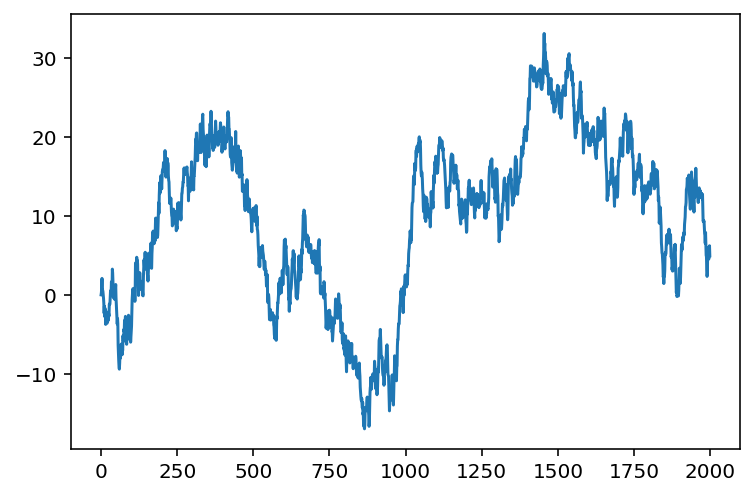

In [75]:
## Simulate a Wiener process
# feel free to change these
N_measurement_times = 2000 # number of measurements
dt = 2 * 10 # time between_measurements

# list of measurement times
times = np.linspace(0, (N_measurement_times-1) * dt, num=N_measurement_times)

# our Wiener process
W_of_t = []

# remember scale = standard deviation, and above in the text
# we've given the variance
# after some time, N(mean, variance)
normDist = scipy.stats.norm(loc=0, scale=1)
for ii in range(N_measurement_times):
    if ii == 0:
        W_of_t.append(0)
    else:
        # use scipy.stats.n
        W_of_t.append(W_of_t[ii-1] + normDist.rvs())

plt.plot(W_of_t)


When we typically calculate and plot an autocorrelation function in practice, it tells us the correlation between two points separated by some lag $\tau$. But for a Wiener process that doesn't really make much sense, because the correlation here doesn't just depend on the lag.

However, we *can* try to characterize this process in a different way--using the [power-spectral density](https://en.wikipedia.org/wiki/Spectral_density). This describes the power in each frequency, $S(f)$. If we know it analytically, integrating this function over our frequency range should give us the variance, $\int_0^{\infty}S(f) df = \sigma^2$.

The PSD calculated from a set of discretely sampled data is defined as:

$$S(f) = \frac{1}{T_{obs}} |\tilde x(f)|^2,$$

where $T_{obs}$ is the time over which the Fourier transform is taken to get $\tilde x(f)$.

Let's calculate the PSD of our Wiener process. We use "Welch's method," which means that we cut up the time-series data into (in our case 10) chunks, calculate the PSD in each chunk, and then average those 10 PSDs together. This means that we lose some low-frequency information, but get a better estimate of the PSD at all frequencies.

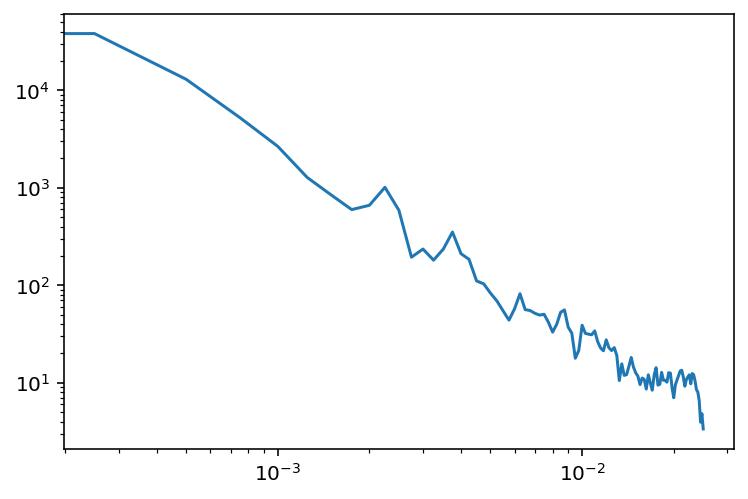

In [76]:
from scipy.signal import welch # method for calculating the PSD
nperseg = int(times[-1] / (10*dt)) + 1 # 10 averages
frequencies, Pxx = welch(W_of_t, fs=1/dt, nperseg=200)
plt.loglog(frequencies, Pxx)
plt.show()

1.  In the cell below calculate the Variance from `Pxx` and `frequencies`. Compare it to `np.var(W_of_t)`. Do they agree? If not, why not? (*hint:* it has to do with Welch's method) 

2. Then go back up to where we simulated the Wiener process. Multiply `dt` by a factor of 10 to simulate a dataset that's even longer, and then re-run all of the cells including the one below. What has happened to the variances? The PSD?



In [77]:
deltaF = frequencies[1] - frequencies[0]
# perform a simple Riemann sum over the PSD
var_from_psd = np.sum(Pxx)
print('PSD integral:', var_from_psd)
# calculate variance of the time series W_of_t
print('Variance of time series:', np.var(W_of_t))



PSD integral: 71074.13887285031
Variance of time series: 108.9917351893985


What happens if, instead of calculating the variance of the time-series itself, we high-pass filter it first, so we only include frequencies that are included in the PSD. Then does the variance agree with our PSD estimate?

In the cell below, we also look at the difference between the low-pass filtered series and the original time-series.

(1, 6)
Variance of low-pass filtered signal 20.66153258518273
Variance from PSD 17.768534718212578
Variance from full time series 108.9917351893985


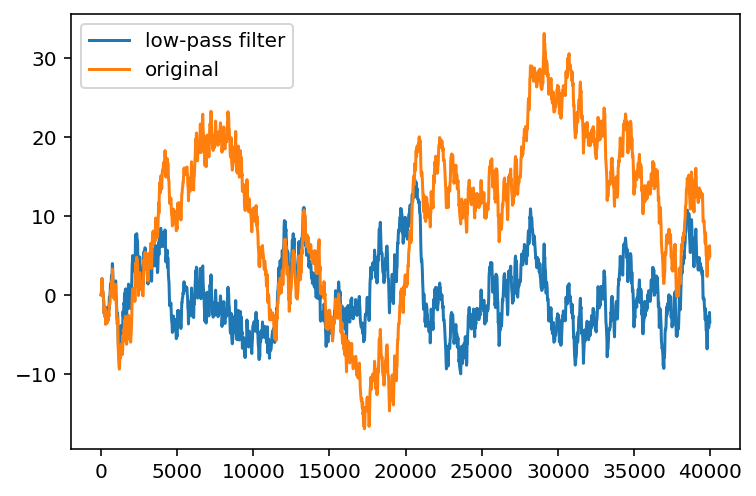

In [80]:
from scipy.signal import butter, sosfilt
# low pass filter so that we only include frequencies in the PSD, then calculate the variance
# use a butterworth filter
sos = butter(2, 1/(2 * nperseg * dt), btype='highpass', fs=1/dt, output='sos')
print(sos.shape)
print('Variance of low-pass filtered signal', np.var(sosfilt(sos, W_of_t)))
print('Variance from PSD', np.sum(Pxx * deltaF))
print('Variance from full time series', np.var(W_of_t))

plt.plot(times, sosfilt(sos, W_of_t), label='low-pass filter')
plt.plot(times, W_of_t, label='original')
plt.legend()
plt.show()

### What is the PSD of a Wiener process?

There are a few ways to calculate it analytically. Both of which are a bit suspect. The [**Wiener-Khinchin Theoerem**](https://en.wikipedia.org/wiki/Wiener%E2%80%93Khinchin_theorem) says that the PSD (of a *wide sense stationary function*!!) is the Fourier transform of the autocorrelation function, $R(\tau)$. We don't have a WSS function, but we can try it anyway and see what happens.

If $$W_t = \int_0^t dt' \xi(t'),$$ then we can wave our hands and say that the Fourier transform of $W_t$, then should be $1/(2\pi f)$ multiplied by the Fourier transform of $\xi(t)$ (implicitly using integration by parts). Since we know the autocorrelation function for $\xi(t)$, we can calculate its PSD first:

$$S_\xi(f) = \int e^{2\pi i f \tau} \delta(\tau) d\tau = 1.$$

By our argument above, then

$$S_W(f) = \frac{1}{4\pi^2 f^2}.$$

/var/folders/1z/bwsppzbn3zd4q4lgr56l76tm0000gn/T/ipykernel_36733/3975270254.py:3: RuntimeWarning: divide by zero encountered in reciprocal
  plt.loglog(frequencies, (4 * np.pi**2 * frequencies**2)**-1, label='Theory')


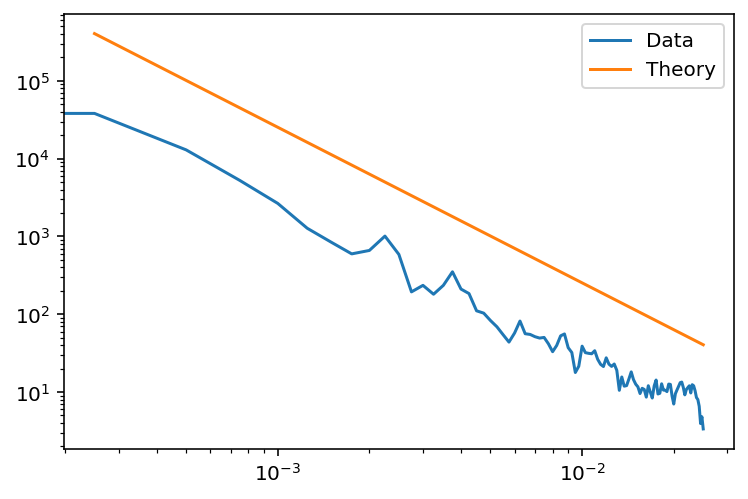

In [84]:
plt.loglog(frequencies, Pxx, label='Data')
# factor of 2 to go to 1-sided PSD, which is what scipy.signal
plt.loglog(frequencies, (4 * np.pi**2 * frequencies**2)**-1, label='Theory')
plt.legend()
plt.show()

### Moral of this story?

Stochastic processes are strange. Be careful when characterizing non-stationary processes, especially with "standard" PSDs used in signal processing. Your intuition will be weird! For example, if you keep taking data for a Wiener process, your PSD will get bigger. Those of us used to LIGO data will find that really (really) weird. 

But this is a common thing in PTAs. We often talk about $1/f^{\alpha}$ noise, which is inherently non-stationary. So we have to be careful when characterizing it using a PSD or the Wiener-Khinchin Theorem.